# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [2]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [3]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [5]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [6]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [7]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [8]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [9]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

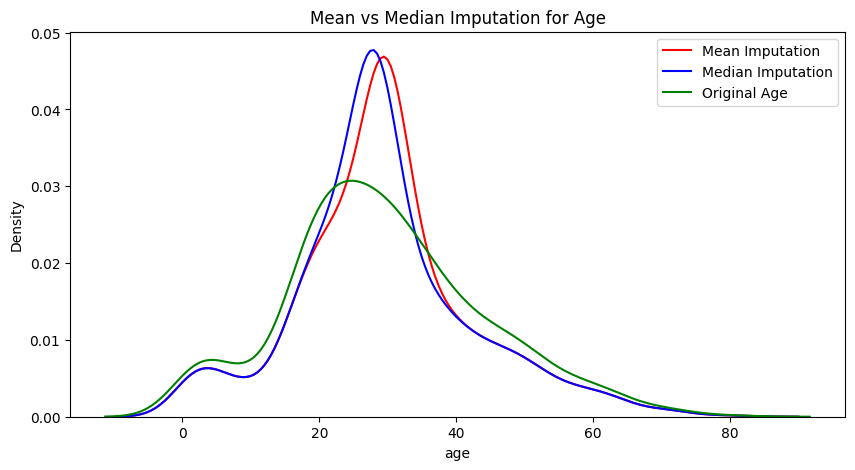

Mode imputation:
 embarked
S    646
C    168
Q     77
Name: count, dtype: int64 

Unknown category:
 embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Load Titanic dataset from seaborn
titanic = sns.load_dataset("titanic")

# 1) Mean vs Median imputation for Age
mean_age = titanic["age"].fillna(titanic["age"].mean())
median_age = titanic["age"].fillna(titanic["age"].median())

# Compare distributions
plt.figure(figsize=(10,5))
sns.kdeplot(mean_age, label="Mean Imputation", color="red")
sns.kdeplot(median_age, label="Median Imputation", color="blue")
sns.kdeplot(titanic["age"].dropna(), label="Original Age", color="green")
plt.legend()
plt.title("Mean vs Median Imputation for Age")
plt.show()

# 2) Embarked fill with 'Unknown' vs mode
mode_embarked = titanic["embarked"].fillna(titanic["embarked"].mode()[0])
unknown_embarked = titanic["embarked"].fillna("Unknown")

print("Mode imputation:\n", mode_embarked.value_counts(), "\n")
print("Unknown category:\n", unknown_embarked.value_counts())


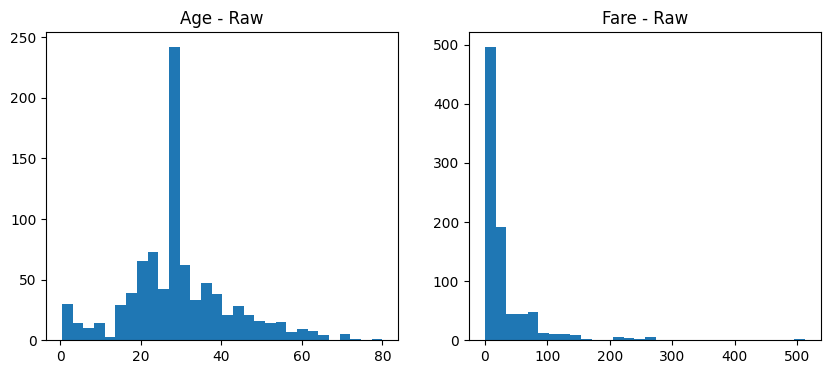

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

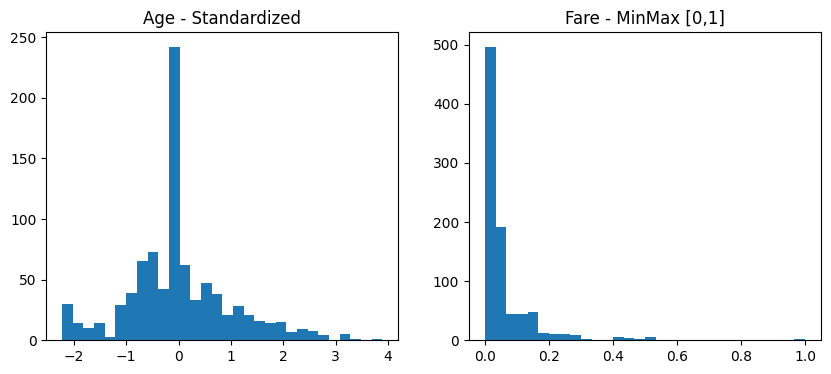

In [11]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

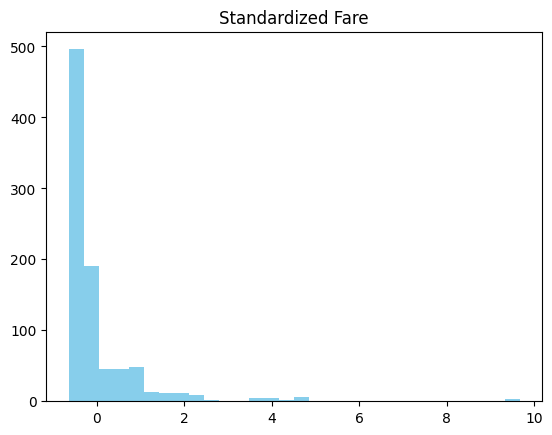

Original:
 [[22.      7.25  ]
 [38.     71.2833]
 [26.      7.925 ]
 [35.     53.1   ]
 [35.      8.05  ]]

Normalized (row-wise):
 [[0.94975704 0.31298812]
 [0.47041706 0.88244422]
 [0.95655127 0.29156418]
 [0.55033828 0.83494178]
 [0.97455519 0.22414769]]


In [21]:
from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np

# 1) Standardize Fare
scaler = StandardScaler()
titanic["fare_std"] = scaler.fit_transform(titanic[["fare"]])

plt.hist(titanic["fare_std"].dropna(), bins=30, color="skyblue")
plt.title("Standardized Fare"); plt.show()

# 2) Normalizer on [Age, Fare]
norm = Normalizer()
subset = titanic[["age", "fare"]].dropna().head(5)
normalized = norm.fit_transform(subset)

print("Original:\n", subset.values)
print("\nNormalized (row-wise):\n", normalized)


## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [12]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [13]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

In [22]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Drop NaN
embarked = titanic[["embarked"]].dropna()

# 1) Ordinal Encoding
ord_enc = OrdinalEncoder()
embarked_ord = ord_enc.fit_transform(embarked)

# 2) One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False)
embarked_ohe = ohe.fit_transform(embarked)

print("Ordinal shape:", embarked_ord.shape)
print("One-Hot shape:", embarked_ohe.shape)
print("One-Hot categories:", ohe.categories_)


Ordinal shape: (889, 1)
One-Hot shape: (889, 3)
One-Hot categories: [array(['C', 'Q', 'S'], dtype=object)]


## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

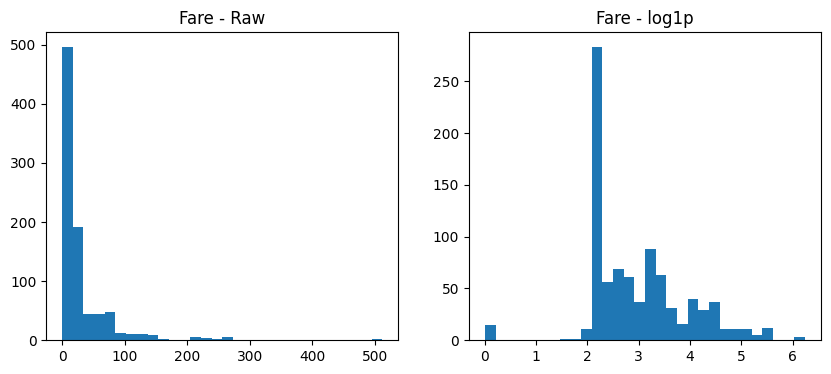

In [14]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

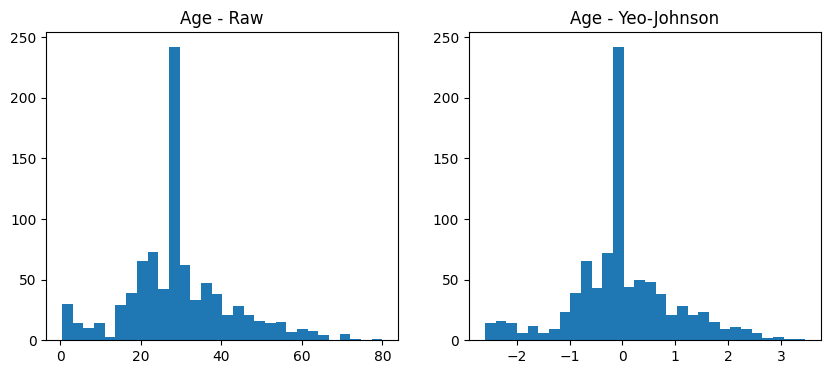

In [15]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [16]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

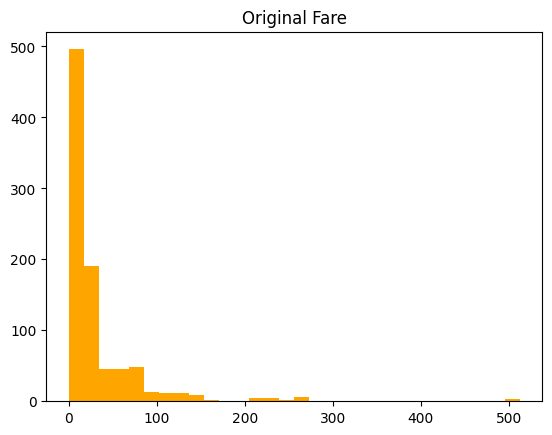

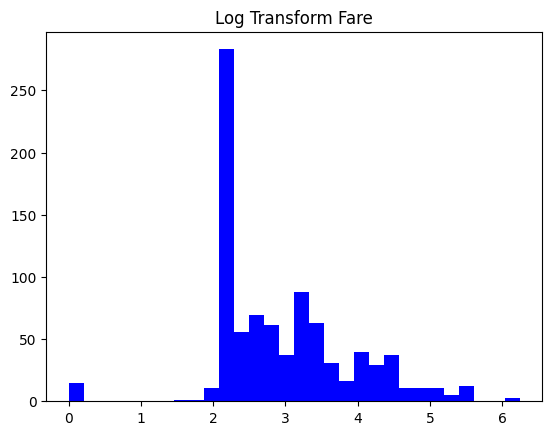

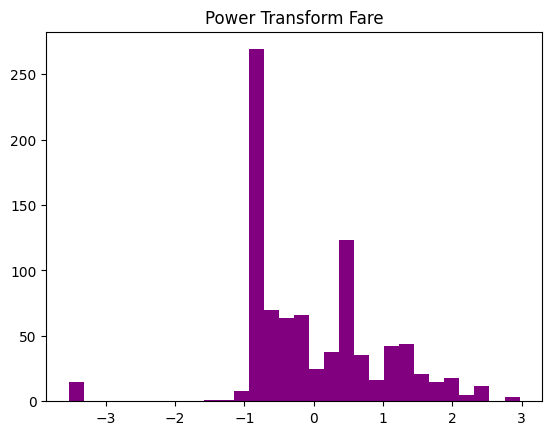

Original subset:
     age     fare
0  22.0   7.2500
1  38.0  71.2833
2  26.0   7.9250
Polynomial terms:
 ['age' 'fare' 'age^2' 'age fare' 'fare^2']
[[  22.            7.25        484.          159.5          52.5625    ]
 [  38.           71.2833     1444.         2708.7654     5081.30885889]
 [  26.            7.925       676.          206.05         62.805625  ]]


In [24]:
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures

# 1) Skewed column: Fare
plt.hist(titanic["fare"].dropna(), bins=30, color="orange"); plt.title("Original Fare"); plt.show()

# Log transform
log_fare = np.log1p(titanic["fare"].dropna())
plt.hist(log_fare, bins=30, color="blue"); plt.title("Log Transform Fare"); plt.show()

# Power transform (Yeo-Johnson)
pt = PowerTransformer(method="yeo-johnson")
fare_power = pt.fit_transform(titanic[["fare"]].dropna())
plt.hist(fare_power, bins=30, color="purple"); plt.title("Power Transform Fare"); plt.show()

# 2) Polynomial features
poly = PolynomialFeatures(2, include_bias=False)
subset = titanic[["age", "fare"]].dropna().head(3)
poly_features = poly.fit_transform(subset)
print("Original subset:\n", subset)
print("Polynomial terms:\n", poly.get_feature_names_out(["age", "fare"]))
print(poly_features)


## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96165195 0.03587775]


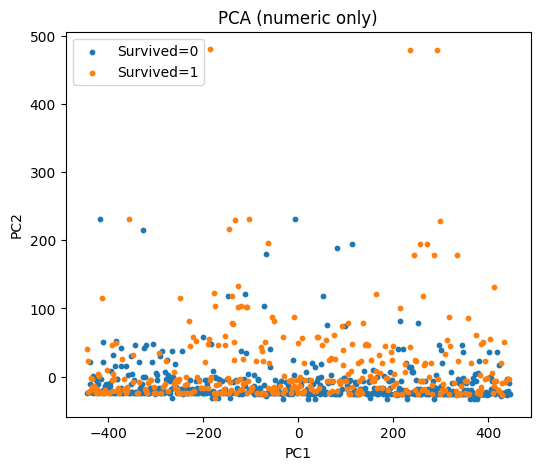

In [17]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [25]:
from sklearn.decomposition import PCA

# 1) Variance
numeric = titanic.select_dtypes(include=np.number).dropna()
print("Top 2 variance columns:\n", numeric.var().sort_values(ascending=False).head(2))

# 2) PCA
pca = PCA(n_components=3)
pca.fit(numeric)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", np.cumsum(pca.explained_variance_ratio_))


Top 2 variance columns:
 fare    2800.413100
age      211.019125
dtype: float64
Explained variance ratio: [9.29962485e-01 6.93542818e-02 3.15751262e-04]
Cumulative variance explained: [0.92996248 0.99931677 0.99963252]


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).